In [1]:
import torch
from torch.utils.data import DataLoader
from model.encoder import Encoder
from model.self_interaction import SelfInteraction
from model.cross_interaction import CrossInteraction
from dataset.qmul_v2_dataset import TestImgDataset
from PIL import Image,ImageDraw
import PIL
from matplotlib import pyplot as plt
from torchvision import transforms
import numpy as np
import os
plt.rcParams['figure.figsize'] = (400.0, 50.0)

In [18]:
def draw_border(img):
    border=img.size[0]-1
    draw=ImageDraw.Draw(img)
    draw.line((0,border,border,border),fill='green',width=10)
    draw.line((0,0,0,border),fill='green',width=10)
    draw.line((border,0,border,border),fill='green',width=10)
    draw.line((0,0,border,0),fill='green',width=10)
    return img

def chair_label_join(label):
    names=label.split('_')
    match_label=''
    for name in names[:-1]:
        match_label+=name
        match_label+='_'
    return match_label[:-1]

def retrieval(img_encoder, sk_encoder, img_loader, sk_path, self_interaction=None, match=None,dataset='qmul'):
    img_encoder.eval()
    sk_encoder.eval()

    with torch.no_grad():
        # processing all val img
        img_list = []
        img_label_list = []
        for img, label in img_loader:
            img = img.cuda()
            if dataset=='sketchy':
                img_fea,_=img_encoder(img)
            else:
                img_fea = img_encoder(img)
            # [B,F]
            if self_interaction:
                img_fea=self_interaction(img_fea)
            img_fea = img_fea.cpu()

            for i in range(img.shape[0]):
                img_list.append(img_fea[i].unsqueeze(0))
                img_label_list.append(label[i])
        img_feas = torch.cat(img_list, dim=0)
        # [img_num,F]

        # retrival
        img_num = len(img_loader.dataset)
        dist_mat = torch.zeros(1,img_num)
        
        norm=transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        input_transform=transforms.Compose([transforms.Resize(256),transforms.ToTensor(), norm])
        sk=Image.open(sk_path)
        if dataset=='qmul':
            sk = sk.split()[3]
            sk = Image.merge('RGB', (sk, sk, sk))
            sk_tensor = input_transform(sk)
            sk=sk_tensor.unsqueeze(0).cuda()

        if dataset=='sketchy':
            sk_fea,_ = sk_encoder(sk)
        else:
            sk_fea = sk_encoder(sk)
            # [B,F]
        if self_interaction:
            sk_fea=self_interaction(sk_fea)
        for i_img in range(0, img_num, 64):
            j_img = min(i_img + 64, img_num)
            dist_mat[:,i_img:j_img] = match(img_feas[i_img:j_img].cuda(), sk_fea).cpu()
                # dist_mat[i_sk:j_sk,
                #          i_img:j_img] = cos_dis(img_feas[i_img:j_img].cuda(),
                #                                 sketch_embedding).cpu()

        indics = torch.sort(dist_mat)[1]
        # [1,img_num]
        res_indics=indics[0,:10]
        res=[]
        for i in res_indics:
            res.append(img_label_list[i])

    return res

In [6]:
ckpt_path='/home/xjq/code/shoe/DLI-Net/ckpt/dli-chair-v2.pth'
img_encoder=Encoder('mid').cuda()
sk_encoder=Encoder('mid').cuda()
ckpt=torch.load(ckpt_path)
img_encoder.load_state_dict(ckpt['encoder_img'])
sk_encoder.load_state_dict(ckpt['encoder_sk'])
self_interaction=SelfInteraction(0.5)
match=CrossInteraction('2norm')

In [21]:
sk_path='/home/xjq/code/dataset/qmul_v2/ChairV2/testA/4834052_v1_White_2.png'
img_test_root='/home/xjq/code/dataset/qmul_v2/ChairV2/testB'
img_test_txt='/home/xjq/code/dataset/qmul_v2/ChairV2/photo_test.txt'
test_img_dataset = TestImgDataset(img_test_root, img_test_txt, 256)
test_img_loader = DataLoader(test_img_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=8)

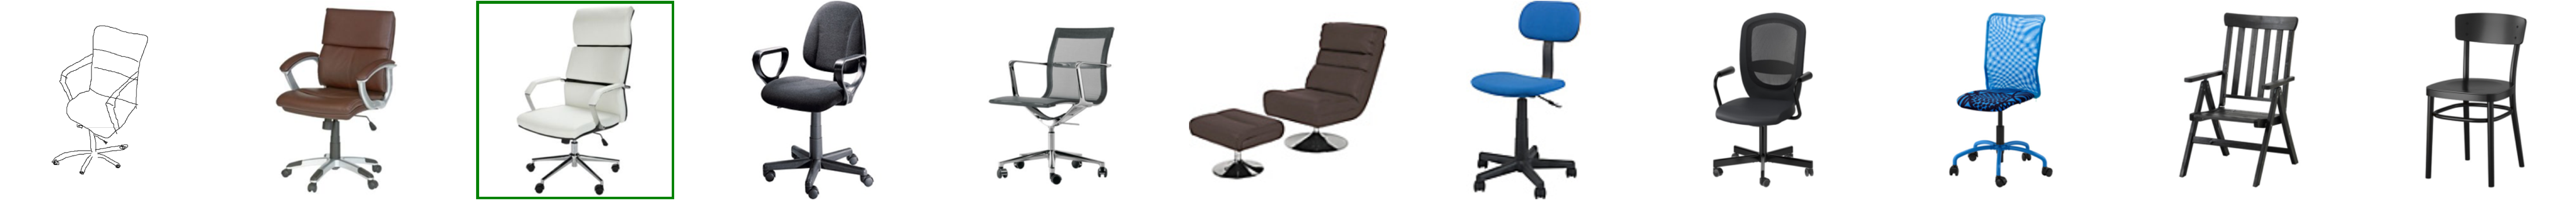

In [23]:
res=retrieval(img_encoder,sk_encoder,test_img_loader,sk_path,self_interaction,match)
fig,ax=plt.subplots(nrows=1,ncols=11)
sk=Image.open(sk_path)
sk=sk.resize((400,400))
sk_label=sk_path.split('/')[-1]
if len(sk_label.split('_'))>2:
    sk_label=chair_label_join(sk_label)
else:
    sk_label=sk_label.split('_')[0]
ax[0].imshow(sk)
ax[0].set_axis_off()
for i in range(1,11):
    img_path=os.path.join(img_test_root,res[i-1]+'.png')
    img=Image.open(img_path)
    img=img.resize((400,400))
    if(res[i-1]==sk_label):
        img=draw_border(img)
    ax[i].imshow(img)
    ax[i].set_axis_off()
plt.savefig('./retrieval.svg')
plt.show()

21
